In [1]:
%matplotlib notebook

import gym
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
import numpy as np


def episode(env, learner, render=False):
    state = env.reset()
    cum_reward = 0
    done = False
    while not done:
        action = learner.choose_action(state)
        next_state, reward, done, info = env.step(action)
        learner.learn(state, action, reward, next_state)
        if render:
            env.render()
        cum_reward += reward
        state = next_state
    return cum_reward


def train(learner, fig, ax, fig2, ax2):
    cum_rewards = []
    test_rewards = []
    for i in range(episodes):
        learner.epsilon = learner.epsilon - eps_start / episodes
        cum_reward = episode(env, learner)
        cum_rewards.append(cum_reward)
        if i % (episodes//20) == 0:
            print("episode %d" % i)
            epsilon = learner.epsilon
            learner.epsilon = 0
            test_rewards.append(sum([episode(env, learner) for _ in range(10)]) / 10.)
            learner.epsilon = epsilon
            ax.plot(cum_rewards)
            fig.canvas.draw()
            ax2.plot(test_rewards)
            fig2.canvas.draw()

def plot(env, learner):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    low = env.observation_space.low
    high = env.observation_space.high
    xs = np.linspace(low[0], high[0], 500)
    ys = np.linspace(low[1], high[1], 500)
    X, Y = np.meshgrid(xs, ys)

    states = np.append(X.reshape(X.shape + (1,)), Y.reshape(Y.shape + (1,)), axis=2)
    states = states.reshape((states.shape[0]*states.shape[1], 2,))
    q = np.array(list(map(lambda x: max([learner.get_q(x, a) for a in learner.actions]), states)))
    Z = -q.reshape(X.shape)

    # plot reward function (multiplied by -1)
    ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
    plt.show()

In [2]:
env = gym.make('MountainCar-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Epislon Greedy Policy

In [3]:
import random
import numpy as np

from abc import ABC, abstractmethod


class AbstractQLearn(ABC):
    def __init__(self, env, epsilon, alpha, gamma):
        self.env = env
        self.epsilon = epsilon  # exploration constant
        self.alpha = alpha  # discount constant
        self.gamma = gamma  # discount factor
        self.actions = range(env.action_space.n)

    @abstractmethod
    def write_q(self, filename):
        raise Exception("Not Implemented")

    @abstractmethod
    def load_q(self, filename):
        raise Exception("Not Implemented")

    @abstractmethod
    def get_q(self, state, action):
        raise Exception("Not Implemented")

    def choose_action(self, state):
        if random.random() < self.epsilon:
            action = random.sample(self.actions, 1)[0]
        else:
            q = [self.get_q(state, action) for action in self.actions]
            action = np.argmax(q)
        return action

    @abstractmethod
    def learn(self, state1, action1, reward, state2):
        raise Exception("Not Implemented")

# Tabular Q-Learning

In [4]:
import pickle

from q import AbstractQLearn


class QLearn(AbstractQLearn):

    def __init__(self, env, epsilon, alpha, gamma, discretisations=10):
        super().__init__(env, epsilon, alpha, gamma)
        self.q = {}
        self.discretisations = discretisations

    def write_q(self, filename):
        with open(filename, "wb") as f:
            pickle.dump(self.q, f)

    def load_q(self, filename):
        with open(filename, "rb") as f:
            self.q = pickle.load(f)
    
    def _discretize(self, state):
        low = self.env.observation_space.low
        high = self.env.observation_space.high
        diff = (high - low) / self.discretisations
        discrete_state = (state - low) // diff
        return tuple(discrete_state.tolist())

    def get_q(self, state, action):
        return self.q.get((self._discretize(state), action), 0.0)

    def learn(self, state1, action1, reward, state2):
        v = reward + self.gamma * max([self.get_q(state2, a) for a in self.actions])
        oldv = self.q.get((self._discretize(state1), action1), None)
        if oldv is None:
            self.q[(self._discretize(state1), action1)] = reward
        else:
            self.q[(self._discretize(state1), action1)] = oldv + self.alpha * (v - oldv)

<IPython.core.display.Javascript object>


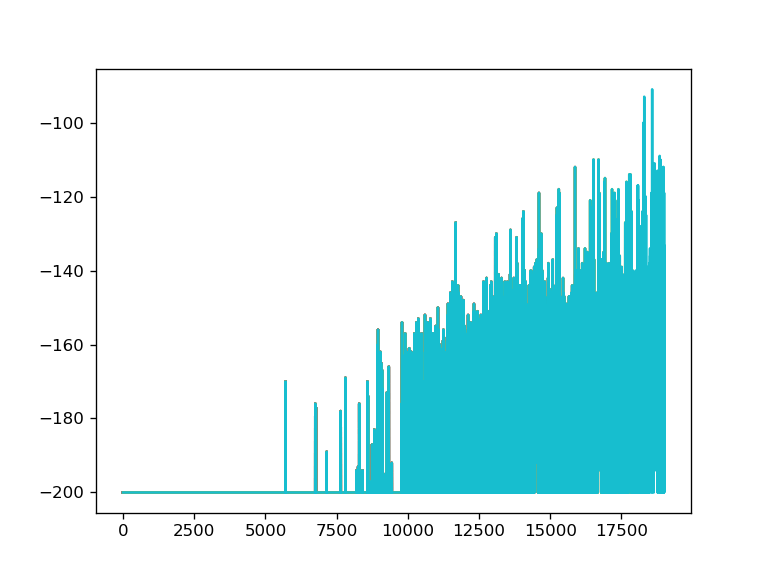

<IPython.core.display.Javascript object>


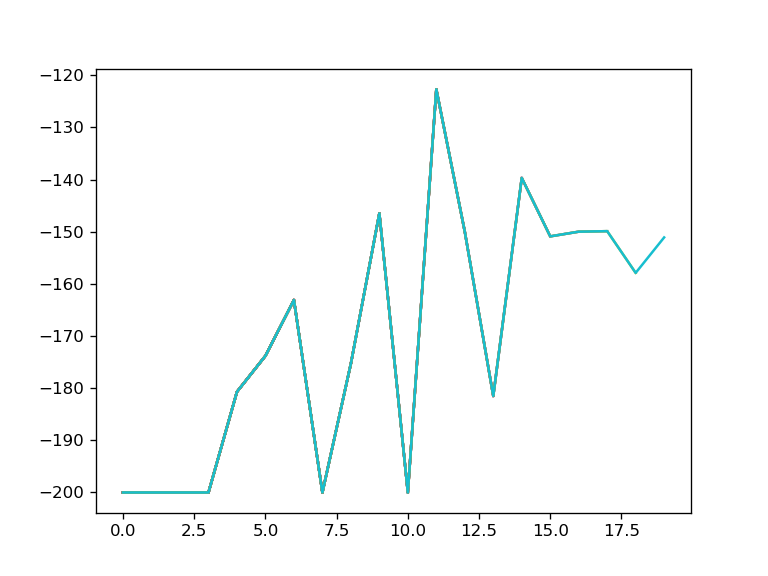

episode 0
episode 1000
episode 2000
episode 3000
episode 4000
episode 5000
episode 6000
episode 7000
episode 8000
episode 9000
episode 10000
episode 11000
episode 12000
episode 13000
episode 14000
episode 15000
episode 16000
episode 17000
episode 18000
episode 19000


In [5]:
env.reset()

eps_start = 0.9
alpha = 0.01
gamma = 0.999
learner = QLearn(env, eps_start, alpha, gamma)

fig,ax = plt.subplots(1,1)
fig2,ax2 = plt.subplots(1,1)

episodes = 20000

train(learner, fig, ax, fig2, ax2)
plt.show()

weights_filename = "weights"+type(learner).__name__+"_"+str(episodes)+".pckl"
learner.write_q(weights_filename)

In [ ]:
# learner.load_q(weights_filename)

In [6]:
epsilon = learner.epsilon
learner.epsilon = 0
for _ in range(5):
    episode(env, learner, True)
learner.epsilon = epsilon

<IPython.core.display.Javascript object>


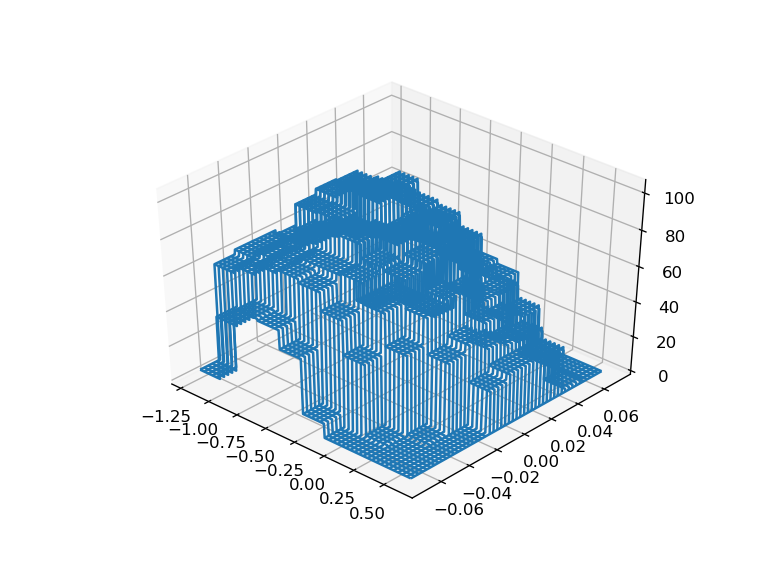

In [7]:
plot(env, learner)

# Q-Learning with Gaussian radial basis

In [8]:
import numpy as np
import pickle

from q import AbstractQLearn


class LinQLearn(AbstractQLearn):

    def __init__(self, env, epsilon, alpha, gamma, basis_functions_per_dimension=15):
        super().__init__(env, epsilon, alpha, gamma)

        low = env.observation_space.low
        high = env.observation_space.high

        xx, yy = np.meshgrid(np.linspace(low[0], high[0], basis_functions_per_dimension),
                             np.linspace(low[1], high[1], basis_functions_per_dimension))
        radials = np.append(xx.reshape(xx.shape + (1,)), yy.reshape(yy.shape + (1,)), axis=2)
        self.radials = radials.reshape((radials.size // 2, 2))

        self.weights = np.random.random((len(self.actions), basis_functions_per_dimension ** 2)) * 0.01
        
        low = env.observation_space.low
        high = env.observation_space.high
        self.sigma_inv = 1 / (high  - low) * basis_functions_per_dimension

    def write_q(self, filename):
        with open(filename, "wb") as f:
            pickle.dump(self.weights, f)

    def load_q(self, filename):
        with open(filename, "rb") as f:
            self.weights = pickle.load(f)
    
    def _basis_functions(self, state):
        r = self.sigma_inv * (self.radials - state)
        return np.exp(-0.5 * np.sum(r * r, axis=1))

    def get_q(self, state, action):
        return np.dot(self._basis_functions(state), self.weights[action])

    def learn(self, state1, action1, reward, state2):
        basis = self._basis_functions(state1)
        v = reward + self.gamma * max([self.get_q(state2, a) for a in self.actions])
        gradient = -2 * np.dot(basis, (v - np.dot(basis, self.weights[action1])))
        self.weights[action1] -= self.alpha * gradient

<IPython.core.display.Javascript object>


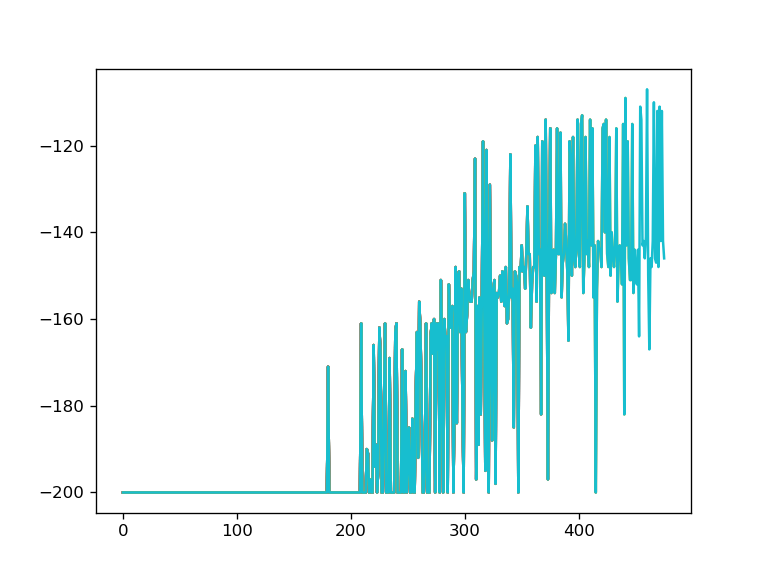

<IPython.core.display.Javascript object>


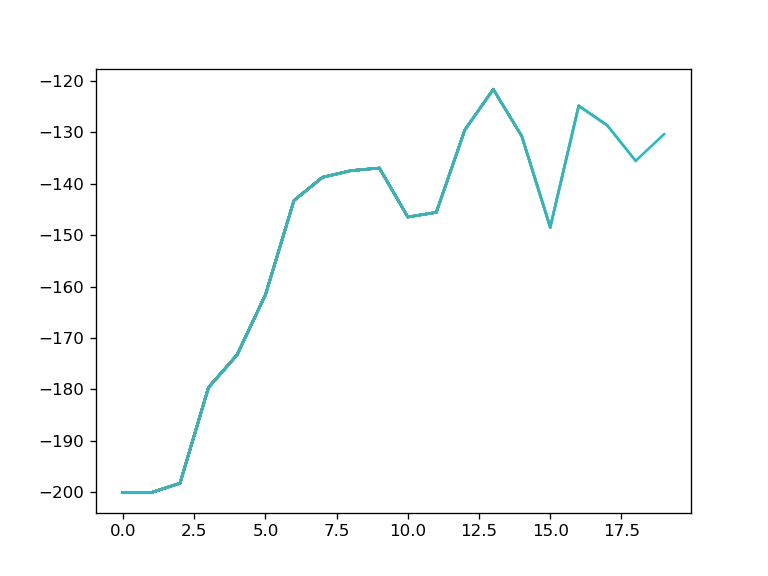

episode 0
episode 25
episode 50
episode 75
episode 100
episode 125
episode 150
episode 175
episode 200
episode 225
episode 250
episode 275
episode 300
episode 325
episode 350
episode 375
episode 400
episode 425
episode 450
episode 475


In [9]:
env.reset()

eps_start = 0.9
alpha = 0.01
gamma = 0.999
learner = LinQLearn(env, eps_start, alpha, gamma)

fig,ax = plt.subplots(1,1)
fig2,ax2 = plt.subplots(1,1)

episodes = 500

train(learner, fig, ax, fig2, ax2)
plt.show()

weights_filename = "weights"+type(learner).__name__+"_"+str(episodes)+".pckl"
learner.write_q(weights_filename)
# learner.load_q(weights_filename)

In [10]:
epsilon = learner.epsilon
learner.epsilon = 0
for _ in range(5):
    episode(env, learner, True)
learner.epsilon = epsilon

<IPython.core.display.Javascript object>


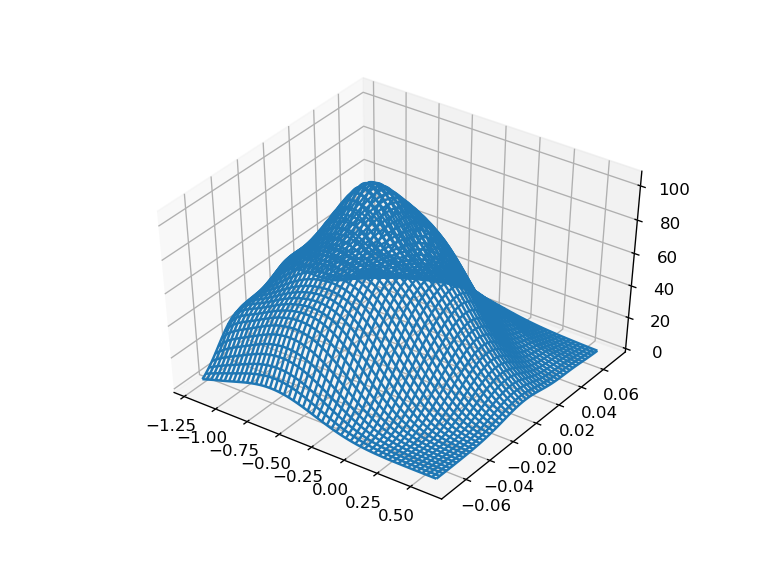

In [11]:
plot(env, learner)

## More Gaussian Kernels

In [13]:
env.reset()

eps_start = 0.9
alpha = 0.01
gamma = 0.999
learner = LinQLearn(env, eps_start, alpha, gamma, 50)

episodes = 9000

In [ ]:
fig,ax = plt.subplots(1,1)
fig2,ax2 = plt.subplots(1,1)

train(learner, fig, ax, fig2, ax2)
plt.show()

In [14]:
weights_filename = "weights"+type(learner).__name__+"_"+str(episodes)+".pckl"
# learner.write_q(weights_filename)
learner.load_q(weights_filename)

<IPython.core.display.Javascript object>


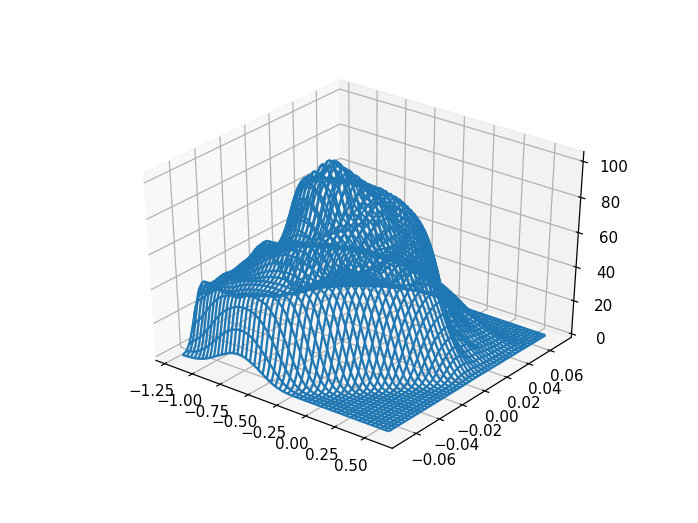

In [15]:
plot(env, learner)

In [16]:
epsilon = learner.epsilon
learner.epsilon = 0
for _ in range(5):
    episode(env, learner, True)
learner.epsilon = epsilon

In [ ]:
env.close()